# MindPulse — ML workflow

Concise notebook demonstrating basic ML concepts: preprocessing, regression, classification, evaluation, and cross-validation.

**Dataset:** `/mnt/data/mindpulse_synthetic.csv` (synthetic data created earlier).

In [17]:
pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

print('Libraries imported')

Libraries imported


In [4]:
df = pd.read_csv('data/mindpulse_synthetic.csv', parse_dates=['timestamp'])
df.head()

,email,name,age,gender,occupation,sleep_hours,exercise_freq,diet_quality,stress_level,anxiety_level,...,social_interaction,work_life_balance,coping_methods,past_mental_illness,current_medication,medication_details,feedback,timestamp,risk_score,risk_label
0,user0@example.com,Priya Deore 0,27.0,Male ♂️,Mechanical Engineer,6.8,1-2 days/week,Poor🔴,6.2,8.0,...,Rarely,Good 🟢,"['Other 🎪', 'Therapy 🪷']",No,No,NaN,NaN,2025-11-28 17:33:00,6.73,Moderate
1,user1@example.com,Amar Mehta 1,22.0,Male ♂️,Doctor,7.8,1-2 days/week,Average🟠,2.9,2.0,...,Sometimes,Excellent 🔵,"['Dancing 💃', 'Therapy 🪷', 'Talking to friends...",No,No,NaN,NaN,2025-11-05 23:38:00,2.42,Low
2,user2@example.com,Kunal Iyer 2,19.0,Male ♂️,Business Man,7.5,3-5 days/week,Good🟢,3.0,1.2,...,Often,Good 🟢,"['Therapy 🪷', 'Exercise 🏋️\u200d♂️', 'Running ...",No,No,NaN,NaN,2025-11-10 02:01:00,2.19,Low
3,user3@example.com,Sam Deore 3,22.0,Male ♂️,Analyst,7.2,3-5 days/week,NaN,2.5,4.4,...,Often,Excellent 🔵,"['Sketching ✒️', 'Talking to friends/family 🫂']",No,No,NaN,NaN,2025-11-30 19:49:00,2.75,Low
4,user4@example.com,Kunal Joshi 4,24.0,Female ♀️,Doctor,5.4,3-5 days/week,Average🟠,6.5,1.6,...,Sometimes,NaN,"['Journaling 📚', 'Hobbies 🎭', 'Talking to frie...",No,No,NaN,NaN,2025-11-02 19:03:00,4.49,Moderate


In [5]:
print('rows, cols:', df.shape)
print('\nMissing values per column:\n', df.isna().sum())
print('\nRisk label distribution:\n', df['risk_label'].value_counts())

rows, cols: (350, 21)

Missing values per column:
 email                    0
name                     0
age                      0
gender                   0
occupation               0
sleep_hours              0
exercise_freq           70
diet_quality            18
stress_level             0
anxiety_level            0
depression_level         0
social_interaction       0
work_life_balance       21
coping_methods           0
past_mental_illness      0
current_medication       0
medication_details     328
feedback               287
timestamp                0
risk_score               0
risk_label               0
dtype: int64

Risk label distribution:
 risk_label
Moderate    217
Low         118
High         15
Name: count, dtype: int64


In [6]:
def coping_count(s):
    try:
        s = str(s)
        s = s.strip('[] ')
        if not s:
            return 0
        parts = [p for p in s.split(',') if p.strip()]
        return len(parts)
    except:
        return 0

df['coping_count'] = df['coping_methods'].apply(coping_count)

for col in ['diet_quality','work_life_balance']:
    df[col] = df[col].fillna('').astype(str).str.replace('🔴','').str.replace('🟠','').str.replace('🟢','').str.replace('🔵','').str.strip()

df['exercise_freq'] = df['exercise_freq'].fillna('').astype(str).str.strip()

df[['age','sleep_hours','coping_count','exercise_freq','diet_quality','social_interaction','work_life_balance']].head()

,age,sleep_hours,coping_count,exercise_freq,diet_quality,social_interaction,work_life_balance
0,27.0,6.8,2,1-2 days/week,Poor,Rarely,Good
1,22.0,7.8,3,1-2 days/week,Average,Sometimes,Excellent
2,19.0,7.5,4,3-5 days/week,Good,Often,Good
3,22.0,7.2,2,3-5 days/week,,Often,Excellent
4,24.0,5.4,3,3-5 days/week,Average,Sometimes,


In [7]:
features = ['age','sleep_hours','coping_count','exercise_freq','diet_quality','social_interaction','work_life_balance']
X = df[features].copy()
y_reg = df['risk_score'].copy()
y_clf = df['risk_label'].astype(str).copy()

X.head()

,age,sleep_hours,coping_count,exercise_freq,diet_quality,social_interaction,work_life_balance
0,27.0,6.8,2,1-2 days/week,Poor,Rarely,Good
1,22.0,7.8,3,1-2 days/week,Average,Sometimes,Excellent
2,19.0,7.5,4,3-5 days/week,Good,Often,Good
3,22.0,7.2,2,3-5 days/week,,Often,Excellent
4,24.0,5.4,3,3-5 days/week,Average,Sometimes,


- Numeric columns: impute median + standard scaling
- Ordinal columns: OrdinalEncoder with sensible ordering
- Note: for demonstration we keep pipeline simple and reproducible.

In [8]:
numeric_cols = ['age','sleep_hours','coping_count']
ordinal_cols = ['exercise_freq','diet_quality','work_life_balance']

ord_enc = OrdinalEncoder(categories=[
    ['', 'None', '1-2 days/week', '3-5 days/week', 'Daily'],
    ['', 'Poor', 'Average', 'Good', 'Excellent'],
    ['', 'Poor', 'Fair', 'Good', 'Excellent']
], handle_unknown='use_encoded_value', unknown_value=-1)

num_pipeline = Pipeline([('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler())])
ord_pipeline = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='')), ('ord', ord_enc)])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, numeric_cols),
    ('ord', ord_pipeline, ordinal_cols)
])

Train / Test split

We use a random split; for classification ensure stratify when possible.

In [9]:
X_proc = preprocessor.fit_transform(X)
print('Processed shape:', X_proc.shape)

Processed shape: (350, 6)


In [10]:
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_proc, y_reg, test_size=0.2, random_state=42)
print('Regression train/test sizes:', Xr_train.shape[0], Xr_test.shape[0])

Regression train/test sizes: 280 70


In [12]:
print('Class counts:\n', y_clf.value_counts())
stratify_param = y_clf if y_clf.value_counts().min() > 1 else None
Xc_train, Xc_test, yc_train, yc_test = train_test_split(X_proc, y_clf, test_size=0.2, random_state=42, stratify=stratify_param)
print('Classification train/test sizes:', Xc_train.shape[0], Xc_test.shape[0])

Class counts:
 risk_label
Moderate    217
Low         118
High         15
Name: count, dtype: int64
Classification train/test sizes: 280 70


In [13]:
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(Xc_train, yc_train)
yc_pred_knn = knn_clf.predict(Xc_test)
print('KNN accuracy:', round(accuracy_score(yc_test, yc_pred_knn),4))
print('Confusion matrix:\n', confusion_matrix(yc_test, yc_pred_knn))
print('Classification report:\n', classification_report(yc_test, yc_pred_knn, zero_division=0))

KNN accuracy: 0.5571
Confusion matrix:
 [[ 1  0  2]
 [ 0  7 17]
 [ 0 12 31]]
Classification report:
               precision    recall  f1-score   support

        High       1.00      0.33      0.50         3
         Low       0.37      0.29      0.33        24
    Moderate       0.62      0.72      0.67        43

    accuracy                           0.56        70
   macro avg       0.66      0.45      0.50        70
weighted avg       0.55      0.56      0.54        70



In [14]:
logreg = LogisticRegression(multi_class='multinomial', max_iter=300)
logreg.fit(Xc_train, yc_train)
yc_pred_lr = logreg.predict(Xc_test)
print('LogisticRegression accuracy:', round(accuracy_score(yc_test, yc_pred_lr),4))
print('Classification report:\n', classification_report(yc_test, yc_pred_lr, zero_division=0))

LogisticRegression accuracy: 0.6
Classification report:
               precision    recall  f1-score   support

        High       0.00      0.00      0.00         3
         Low       0.46      0.25      0.32        24
    Moderate       0.63      0.84      0.72        43

    accuracy                           0.60        70
   macro avg       0.36      0.36      0.35        70
weighted avg       0.55      0.60      0.55        70



c:\Users\Harsh Jethwa\OneDrive\Desktop\the_new_mindpulse\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


- Use CV to evaluate KNN regressor and classifier
- GridSearch for k in KNN (small grid for demo)

In [15]:
cv_scores = cross_val_score(KNeighborsRegressor(n_neighbors=5), X_proc, y_reg, cv=5, scoring='r2')
print('KNNRegressor CV R2 (5-fold):', np.round(cv_scores,4))
print('Mean R2:', round(cv_scores.mean(),4))

KNNRegressor CV R2 (5-fold): [-0.0549 -0.2822 -0.1296  0.081  -0.1139]
Mean R2: -0.0999


In [16]:
param_grid = {'n_neighbors':[3,5,7]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=3, scoring='accuracy')
grid.fit(X_proc, y_clf)
print('Best params (KNNClassifier):', grid.best_params_)
print('Best CV score:', round(grid.best_score_,4))

Best params (KNNClassifier): {'n_neighbors': 3}
Best CV score: 0.5428


Visualizations

In [19]:
df_vis = df.copy()

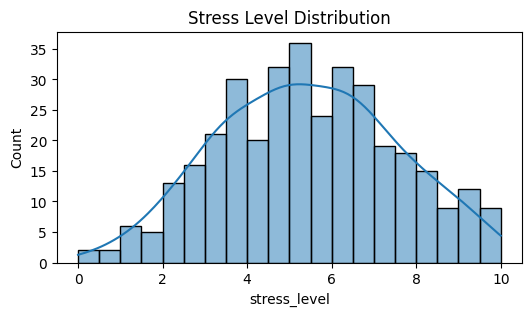

In [41]:
plt.figure(figsize=(6,3))
sns.histplot(df_vis["stress_level"], kde=True, bins=20)
plt.title("Stress Level Distribution")
plt.show()

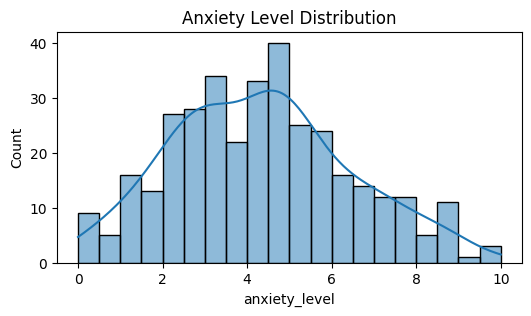

In [40]:
plt.figure(figsize=(6,3))
sns.histplot(df_vis["anxiety_level"], kde=True, bins=20)
plt.title("Anxiety Level Distribution")
plt.show()

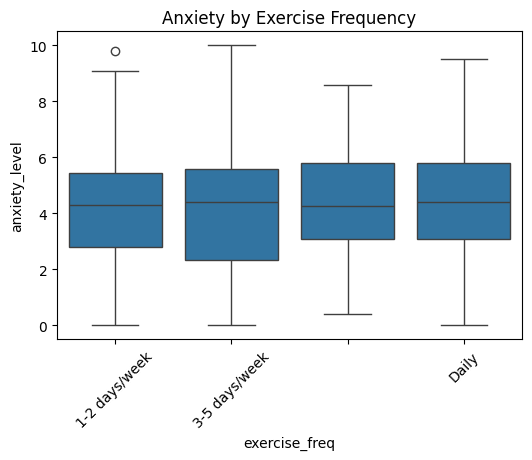

In [39]:
plt.figure(figsize=(6,4))
sns.boxplot(x="exercise_freq", y="anxiety_level", data=df_vis)
plt.title("Anxiety by Exercise Frequency")
plt.xticks(rotation=45)
plt.show()

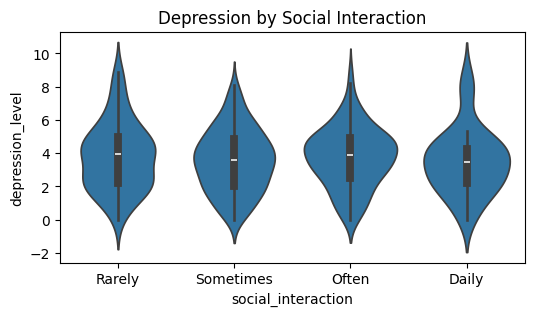

In [38]:
plt.figure(figsize=(6,3))
sns.violinplot(x="social_interaction", y="depression_level", data=df_vis)
plt.title("Depression by Social Interaction")
plt.show()

In [25]:
num_cols = ["stress_level","anxiety_level","depression_level","sleep_hours","age","coping_count","risk_score"]

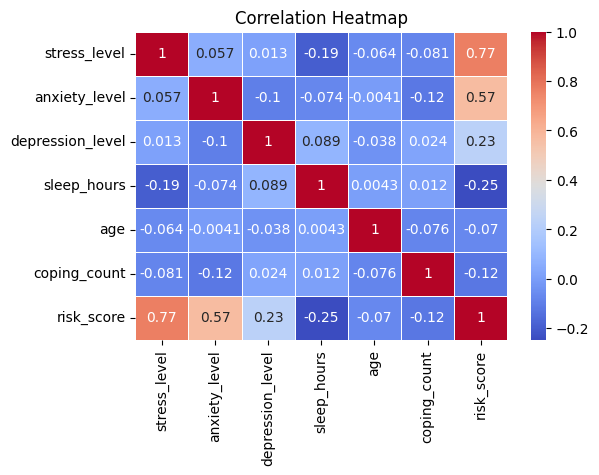

In [37]:
plt.figure(figsize=(6,4))
corr = df_vis[num_cols].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()

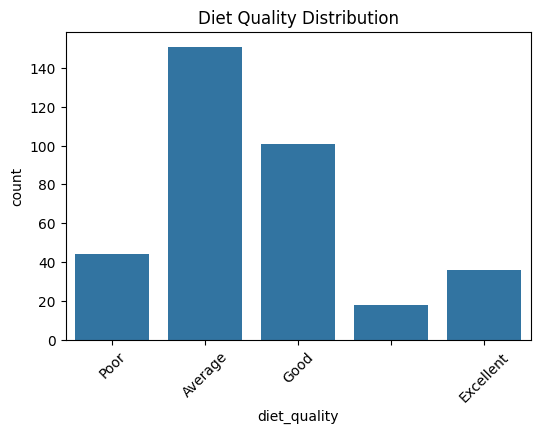

In [36]:
plt.figure(figsize=(6,4))
sns.countplot(x="diet_quality", data=df_vis)
plt.title("Diet Quality Distribution")
plt.xticks(rotation=45)
plt.show()

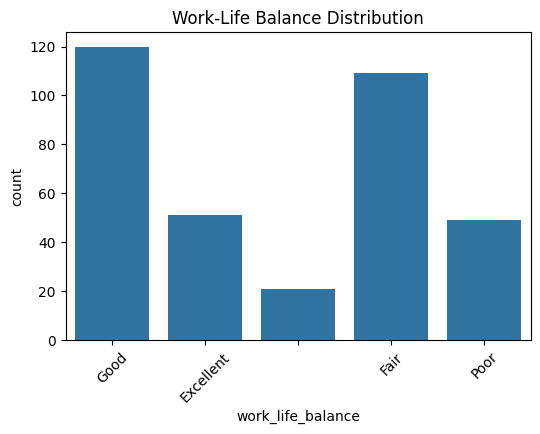

In [35]:
plt.figure(figsize=(6,4))
sns.countplot(x="work_life_balance", data=df_vis)
plt.title("Work-Life Balance Distribution")
plt.xticks(rotation=45)
plt.show()


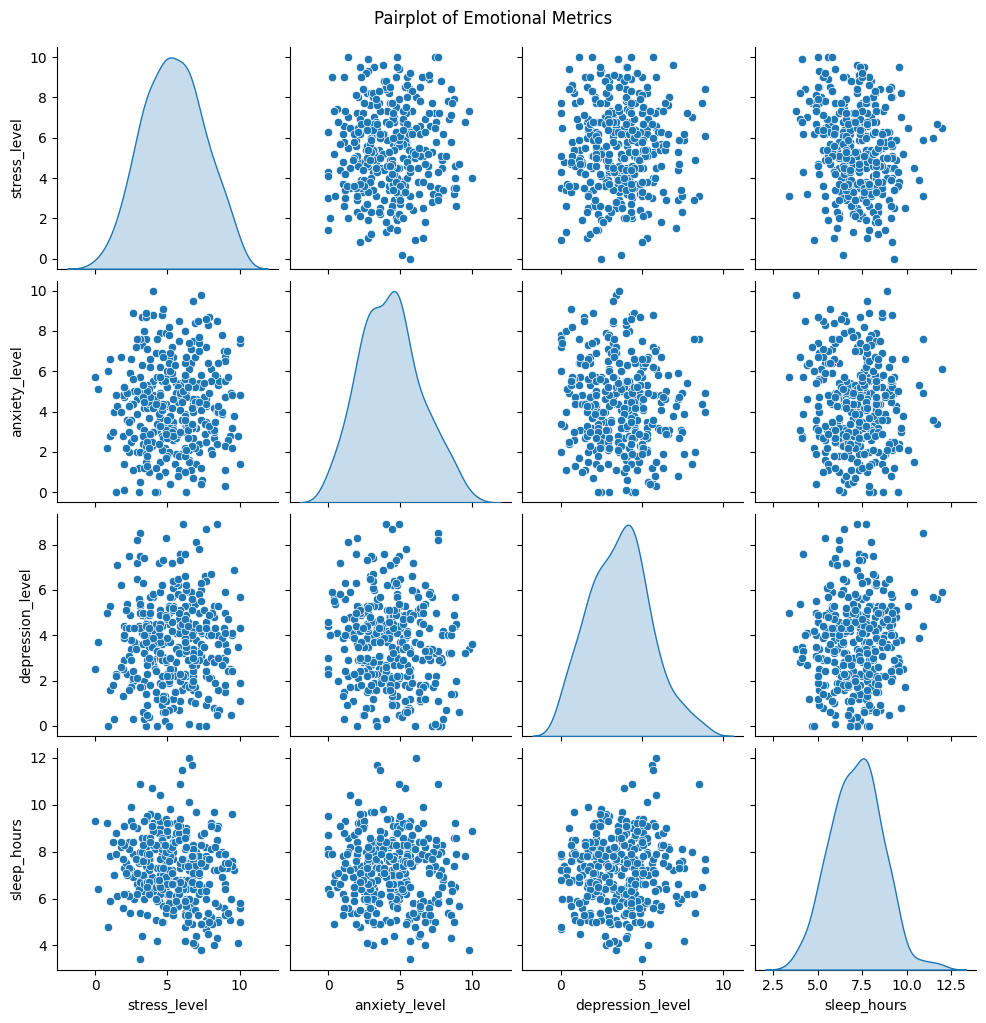

In [29]:
sns.pairplot(df_vis[["stress_level","anxiety_level","depression_level","sleep_hours"]], diag_kind="kde")
plt.suptitle("Pairplot of Emotional Metrics", y=1.02)
plt.show()

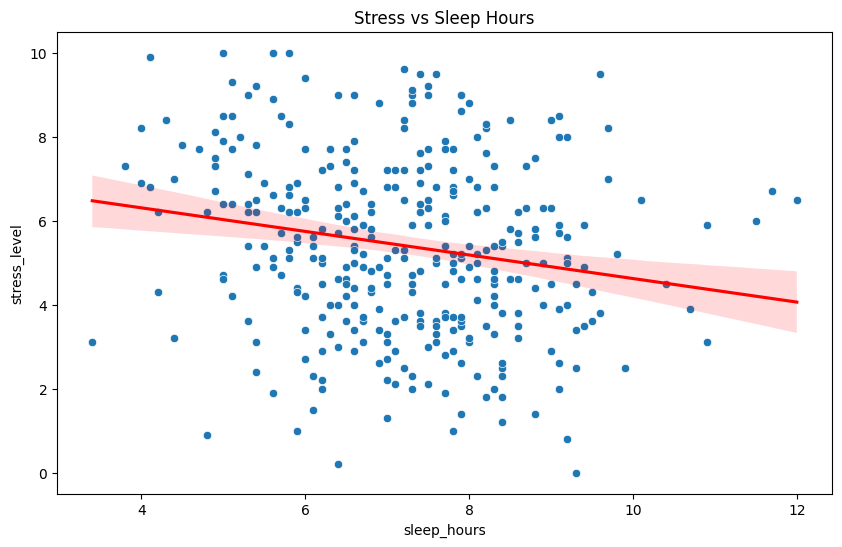

In [31]:
plt.figure(figsize=(10,6))
sns.scatterplot(x="sleep_hours", y="stress_level", data=df_vis)
sns.regplot(x="sleep_hours", y="stress_level", data=df_vis, scatter=False, color="red")
plt.title("Stress vs Sleep Hours")
plt.show()


C:\Users\Harsh Jethwa\AppData\Local\Temp\ipykernel_8436\3405399147.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="social_interaction", y="stress_level", data=df_vis, ci=None)


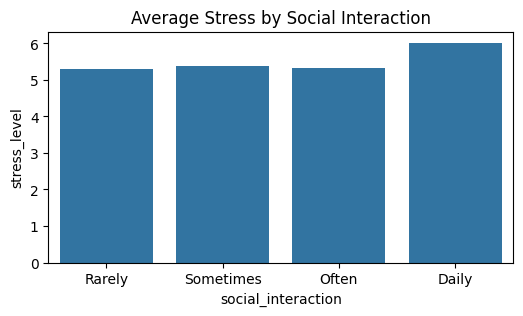

In [42]:
plt.figure(figsize=(6,3))
sns.barplot(x="social_interaction", y="stress_level", data=df_vis, ci=None)
plt.title("Average Stress by Social Interaction")
plt.show()

C:\Users\Harsh Jethwa\AppData\Local\Temp\ipykernel_8436\2880751155.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x="exercise_freq", y="anxiety_level", data=df_vis, ci=None)


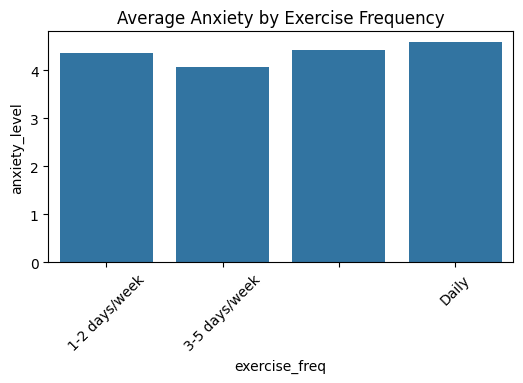

In [43]:
plt.figure(figsize=(6,3))
sns.barplot(x="exercise_freq", y="anxiety_level", data=df_vis, ci=None)
plt.title("Average Anxiety by Exercise Frequency")
plt.xticks(rotation=45)
plt.show()